In [ ]:
#imports
import praw
import pandas as pd
import time
from datetime import datetime, timedelta
import re
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
from datetime import datetime
import time

In [ ]:
class FlexibleDatasetBuilder:
    def __init__(self, client_id, client_secret, user_agent, search_terms, dataset_name="Custom"):
        """
        Initialize Reddit instance for building dataset with custom search terms
        """
        self.reddit = praw.Reddit(
            client_id=client_id,
            client_secret=client_secret,
            user_agent=user_agent
        )

        # Track progress
        self.total_collected = 0
        self.year_stats = defaultdict(int)

        # Search terms and dataset info
        self.search_terms = [term.lower() for term in search_terms]
        self.dataset_name = dataset_name

        print(f"Connected to Reddit API - Ready to build {dataset_name} dataset")
        print(f"Search terms: {search_terms}")

    def contains_search_terms(self, text):
        """Check if text contains any of the search terms (case insensitive)"""
        if not text:
            return False
        text_lower = text.lower()
        return any(term in text_lower for term in self.search_terms)

    def extract_year(self, timestamp):
        """Extract year from UTC timestamp"""
        return datetime.fromtimestamp(timestamp).year

    def scrape_subreddit_comprehensive(self, subreddit_name):
        """
        Scrape a subreddit comprehensively - get as much data as possible
        """
        print(f"\n=== Comprehensive scraping of r/{subreddit_name} ===")
        subreddit_data = []

        try:
            subreddit = self.reddit.subreddit(subreddit_name)

            # Multiple approaches to get maximum coverage
            search_configs = [
                ('top', 'all'),
                ('top', 'year'),
                ('top', 'month'),
                ('top', 'week'),
                ('top', 'day'),
                ('hot', None),
                ('new', None),
                ('rising', None),
                ('controversial', 'all'),
                ('controversial', 'year'),
                ('controversial', 'month')
            ]

            for sort_method, time_filter in search_configs:
                print(f"  Fetching {sort_method} posts" + (f" from {time_filter}" if time_filter else ""))

                try:
                    # Get maximum allowed posts (Reddit typically allows ~1000 max per request)
                    if sort_method == 'top':
                        posts = subreddit.top(time_filter=time_filter, limit=None)  # None = get all available
                    elif sort_method == 'hot':
                        posts = subreddit.hot(limit=None)
                    elif sort_method == 'new':
                        posts = subreddit.new(limit=None)
                    elif sort_method == 'rising':
                        posts = subreddit.rising(limit=None)
                    elif sort_method == 'controversial':
                        posts = subreddit.controversial(time_filter=time_filter, limit=None)

                    batch_count = 0
                    processed_count = 0

                    for submission in posts:
                        processed_count += 1

                        # Check if title or content contains search terms
                        if self.contains_search_terms(submission.title) or self.contains_search_terms(submission.selftext):
                            year = self.extract_year(submission.created_utc)

                            post_data = {
                                'title': submission.title.strip(),
                                'score': submission.score,
                                'tag': submission.link_flair_text if submission.link_flair_text else 'None',
                                'year': year,
                                'subreddit': subreddit_name,
                                'post_id': submission.id,
                                'created_date': datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d'),
                                'num_comments': submission.num_comments,
                                'selftext': submission.selftext[:500] if submission.selftext else '',  # First 500 chars
                                'upvote_ratio': submission.upvote_ratio
                            }

                            subreddit_data.append(post_data)
                            self.year_stats[year] += 1
                            batch_count += 1

                            if batch_count % 50 == 0:
                                print(f"    Found {batch_count} matching posts (processed {processed_count} total)...")

                        # Safety check - if we've processed too many without finding matches, break
                        if processed_count > 5000 and batch_count == 0:
                            print(f"    Processed {processed_count} posts with no matches, moving on...")
                            break

                    print(f"    Collected {batch_count} posts from {sort_method} (processed {processed_count} total)")

                    # More conservative rate limiting for comprehensive scraping
                    time.sleep(5)

                except Exception as e:
                    print(f"    Error with {sort_method}: {e}")
                    continue

        except Exception as e:
            print(f"Error accessing r/{subreddit_name}: {e}")

        # Remove duplicates based on post_id
        unique_data = {}
        for post in subreddit_data:
            unique_data[post['post_id']] = post

        final_data = list(unique_data.values())
        print(f"Final count for r/{subreddit_name}: {len(final_data)} unique posts")

        return final_data

    def search_across_reddit_comprehensive(self, queries):
        """
        Search across all of Reddit comprehensively
        """
        print(f"\n=== Comprehensive Reddit search ===")
        search_data = []

        for query in queries:
            print(f"Searching for: '{query}'")

            try:
                # Search with all available time filters and sort methods
                search_configs = [
                    ('top', 'all'),
                    ('top', 'year'),
                    ('top', 'month'),
                    ('top', 'week'),
                    ('top', 'day'),
                    ('new', 'all'),
                    ('comments', 'all'),
                    ('hot', 'all')
                ]

                for sort_method, time_filter in search_configs:
                    print(f"  {sort_method.title()} results from {time_filter}")

                    try:
                        submissions = self.reddit.subreddit("all").search(
                            query,
                            limit=None,  # Get all available results
                            time_filter=time_filter,
                            sort=sort_method
                        )

                        batch_count = 0
                        processed_count = 0

                        for submission in submissions:
                            processed_count += 1

                            # Double-check that it contains search terms
                            if self.contains_search_terms(submission.title) or self.contains_search_terms(submission.selftext):
                                year = self.extract_year(submission.created_utc)

                                post_data = {
                                    'title': submission.title.strip(),
                                    'score': submission.score,
                                    'tag': submission.link_flair_text if submission.link_flair_text else 'None',
                                    'year': year,
                                    'subreddit': str(submission.subreddit),
                                    'post_id': submission.id,
                                    'created_date': datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d'),
                                    'num_comments': submission.num_comments,
                                    'selftext': submission.selftext[:500] if submission.selftext else '',
                                    'upvote_ratio': submission.upvote_ratio
                                }

                                search_data.append(post_data)
                                self.year_stats[year] += 1
                                batch_count += 1

                                if batch_count % 100 == 0:
                                    print(f"      Found {batch_count} matching posts...")

                            # Safety break if processing too many without matches
                            if processed_count > 2000 and batch_count < 10:
                                print(f"      Processed {processed_count} posts, low match rate, moving on...")
                                break

                        print(f"    Collected {batch_count} posts for '{query}' - {sort_method}/{time_filter}")

                        # Conservative rate limiting for search
                        time.sleep(8)

                    except Exception as e:
                        print(f"    Error with {sort_method}/{time_filter}: {e}")
                        continue

            except Exception as e:
                print(f"Error searching for '{query}': {e}")
                continue

        # Remove duplicates
        unique_data = {}
        for post in search_data:
            unique_data[post['post_id']] = post

        final_data = list(unique_data.values())
        print(f"Total from comprehensive Reddit search: {len(final_data)} unique posts")

        return final_data

    def scrape_comments_from_posts(self, post_ids, max_comments_per_post=50):
        """
        NEW: Scrape comments from posts to find more conversations
        """
        print(f"\n=== Scraping comments from {len(post_ids)} posts ===")
        comment_data = []

        for i, post_id in enumerate(post_ids):
            try:
                submission = self.reddit.submission(id=post_id)
                submission.comments.replace_more(limit=0)  # Don't load "more comments"

                comment_count = 0
                for comment in submission.comments.list():
                    if hasattr(comment, 'body') and self.contains_search_terms(comment.body):
                        year = self.extract_year(comment.created_utc)

                        comment_data.append({
                            'title': f"Comment: {comment.body[:100]}...",  # First 100 chars as title
                            'score': comment.score,
                            'tag': 'Comment',
                            'year': year,
                            'subreddit': str(submission.subreddit),
                            'post_id': f"comment_{comment.id}",
                            'created_date': datetime.fromtimestamp(comment.created_utc).strftime('%Y-%m-%d'),
                            'num_comments': 0,
                            'selftext': comment.body[:500] if comment.body else '',
                            'upvote_ratio': 1.0,
                            'parent_post_id': post_id
                        })

                        comment_count += 1
                        if comment_count >= max_comments_per_post:
                            break

                if i % 10 == 0:
                    print(f"    Processed {i+1}/{len(post_ids)} posts, found {len(comment_data)} matching comments")

                # Rate limiting for comment scraping
                time.sleep(2)

            except Exception as e:
                print(f"    Error processing post {post_id}: {e}")
                continue

        print(f"Collected {len(comment_data)} matching comments")
        return comment_data

    def build_comprehensive_dataset(self, target_subreddits=None, search_queries=None, include_comments=False):
        """
        Build the most comprehensive dataset possible
        """
        print(f"🎯 BUILDING COMPREHENSIVE {self.dataset_name} DATASET")
        print("⚠️  WARNING: This will take a LONG time and may hit rate limits!")
        print("="*70)

        all_data = []

        # 1. Scrape target subreddits comprehensively
        if target_subreddits is None:
            target_subreddits = [
                'WeightLossAdvice', 'loseit', 'diabetes', 'diabetes_t2', 'PCOS',
                'WeightWatchers', 'intermittentfasting', 'progresspics', 'SuperMorbidlyObese',
                'PlusSize', '1200isplenty', 'xxketo', 'Fitness', 'nutrition', 'keto',
                'obesity', 'fatlogic', 'BingeEatingDisorder', 'EDAnonymous',
                'MealPrepSunday', 'BodyAcceptance', 'PlusSize', 'BiggerThanYouThought'
            ]

        for subreddit in target_subreddits:
            subreddit_data = self.scrape_subreddit_comprehensive(subreddit)
            all_data.extend(subreddit_data)

            print(f"\n📊 PROGRESS: {len(all_data)} posts collected so far")
            time.sleep(3)  # Longer pause between subreddits

        # 2. Comprehensive global search
        if search_queries is None:
            search_queries = []
            for term in self.search_terms:
                search_queries.extend([
                    f'{term}',
                    f'{term} experience',
                    f'{term} results',
                    f'{term} side effects',
                    f'{term} weight loss',
                    f'{term} success',
                    f'{term} story',
                    f'{term} journey'
                ])

        search_data = self.search_across_reddit_comprehensive(search_queries)
        all_data.extend(search_data)

        # 3. Optional: Scrape comments from collected posts
        if include_comments and all_data:
            post_ids = [post['post_id'] for post in all_data if not post['post_id'].startswith('comment_')][:100]  # Limit to first 100 posts
            comment_data = self.scrape_comments_from_posts(post_ids)
            all_data.extend(comment_data)

        # 4. Remove duplicates and create DataFrame
        unique_data = {}
        for post in all_data:
            unique_data[post['post_id']] = post

        final_dataset = list(unique_data.values())
        df = pd.DataFrame(final_dataset)

        if not df.empty:
            # Clean and optimize
            df['title'] = df['title'].str.strip()
            df = df[df['title'].str.len() > 10]
            df = df.sort_values(['year', 'score'], ascending=[True, False])
            df = df.reset_index(drop=True)

            self.print_dataset_stats(df)
        else:
            print("⚠️ No data collected!")

        return df

    def print_dataset_stats(self, df):
        """Print comprehensive dataset statistics"""
        print("\n" + "="*60)
        print(f"📈 {self.dataset_name.upper()} DATASET STATISTICS")
        print("="*60)

        print(f"📊 Total items collected: {len(df):,}")

        if not df.empty:
            # Count posts vs comments
            comments = df[df['post_id'].str.startswith('comment_')]
            posts = df[~df['post_id'].str.startswith('comment_')]

            print(f"   • Posts: {len(posts):,}")
            print(f"   • Comments: {len(comments):,}")

            print(f"\n📅 Distribution by year:")
            year_counts = df['year'].value_counts().sort_index()
            for year, count in year_counts.items():
                percentage = (count / len(df)) * 100
                print(f"  {year}: {count:,} items ({percentage:.1f}%)")

            print(f"\n🏷️ Top tags:")
            tag_counts = df['tag'].value_counts().head(10)
            for tag, count in tag_counts.items():
                percentage = (count / len(df)) * 100
                print(f"  {tag}: {count:,} ({percentage:.1f}%)")

            print(f"\n🔥 Top subreddits:")
            sub_counts = df['subreddit'].value_counts().head(15)
            for sub, count in sub_counts.items():
                percentage = (count / len(df)) * 100
                print(f"  r/{sub}: {count:,} ({percentage:.1f}%)")

            print(f"\n📈 Score statistics:")
            print(f"  Mean score: {df['score'].mean():.1f}")
            print(f"  Median score: {df['score'].median():.1f}")
            print(f"  Max score: {df['score'].max():,}")
            print(f"  Min score: {df['score'].min()}")

In [ ]:
# CONFIGURATION
# Reddit API credentials
CLIENT_ID = "..."
CLIENT_SECRET = "..."
USER_AGENT = "..."

DRUG_CONFIGS = {
    "Ozempic": {
        "terms": ['ozempic', 'ozempik', 'ozempiac', 'ozempig', 'ozempoc'],
        "subreddits": ['glp1', 'glp1peptides', 'GLP1microdosing', 'semaglutide', 'Ozempic', 'Ozempic_', 'OzempicForWeightLoss', 'GLP1_Ozempic_Wegovy'],
        "queries": ['ozempic weight loss', 'ozempic diabetes', 'ozempic side effects']
    },
    "Trulicity": {
        "terms": ['trulicity', 'trulisity', 'trulicity injection', 'trulicity pen', 'dulaglutide'],
        "subreddits": ['glp1', 'glp1peptides', 'GLP1microdosing', 'semaglutide', 'diabetes', 'diabetes_t2', 'WeightLossSupport'],
        "queries": ['trulicity diabetes', 'trulicity injection', 'dulaglutide']
    },
    "Wegovy": {
        "terms": ['wegovy', 'wegovi', 'wegovy injection', 'wegovy pen'],
        "subreddits": ['glp1', 'glp1peptides', 'GLP1microdosing', 'semaglutide', 'GLP1_Ozempic_Wegovy', 'Wegovy', 'WegovyUK', 'WegovyweightLoss'],
        "queries": ['wegovy weight loss', 'wegovy results', 'wegovy side effects']
    },
    "Mounjaro": {
        "terms": ['mounjaro', 'monjaro', 'mounjaro injection', 'mounjaro pen', 'tirzepatide'],
        "subreddits": ['glp1', 'glp1peptides', 'GLP1microdosing', 'semaglutide', 'Mounjaro', 'MounjaroMaintenance', 'UKMounjaro', 'Mounjaro_ForType2'],
        "queries": ['mounjaro diabetes', 'mounjaro weight loss', 'tirzepatide']
    },
    "Rybelsus": {
        "terms": ['rybelsus', 'rybelsus tablet', 'rybelsus pill', 'rybelsus oral'],
        "subreddits": ['glp1', 'glp1peptides', 'GLP1microdosing', 'semaglutide', 'RybelsusPill'],
        "queries": ['rybelsus diabetes', 'rybelsus oral', 'rybelsus tablet']
    }
}

print("CONFIGURATION LOADED")
print(f"Ready to scrape {len(DRUG_CONFIGS)} drugs: {list(DRUG_CONFIGS.keys())}")


CONFIGURATION LOADED
Ready to scrape 5 drugs: ['Ozempic', 'Trulicity', 'Wegovy', 'Mounjaro', 'Rybelsus']


In [ ]:
# =============================================================================
# CELL 1: OZEMPIC DATASET
# =============================================================================

print("\n" + "="*60)
print("🧪 SCRAPING OZEMPIC DATASET")
print("="*60)

config = DRUG_CONFIGS["Ozempic"]

# Create scraper instance
scraper_ozempic = FlexibleDatasetBuilder(
    CLIENT_ID, CLIENT_SECRET, USER_AGENT,
    config["terms"], "Ozempic"
)

# Build dataset
df_ozempic = scraper_ozempic.build_comprehensive_dataset(
    target_subreddits=config["subreddits"],
    search_queries=config["queries"]
)

# Save dataset
if not df_ozempic.empty:
    filename = f"ozempic_dataset_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
    df_ozempic.to_csv(filename, index=False)
    print(f"\n SUCCESS! Saved to {filename}")
    print(f" Dataset: {len(df_ozempic)} posts")
else:
    print(f"\n ERROR: No Ozempic data collected")

print(f"\n Waiting 30 seconds before next drug...")
time.sleep(30)

In [ ]:
# =============================================================================
# CELL 2: TRULICITY DATASET
# =============================================================================

print("\n" + "="*60)
print("🧪 SCRAPING TRULICITY DATASET")
print("="*60)

config = DRUG_CONFIGS["Trulicity"]

# Create scraper instance
scraper_trulicity = FlexibleDatasetBuilder(
    CLIENT_ID, CLIENT_SECRET, USER_AGENT,
    config["terms"], "Trulicity"
)

# Build dataset
df_trulicity = scraper_trulicity.build_comprehensive_dataset(
    target_subreddits=config["subreddits"],
    search_queries=config["queries"]
)

# Save dataset
if not df_trulicity.empty:
    filename = f"trulicity_dataset_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
    df_trulicity.to_csv(filename, index=False)
    print(f"\n SUCCESS! Saved to {filename}")
    print(f" Dataset: {len(df_trulicity)} posts")
else:
    print(f"\n ERROR: No Trulicity data collected")

print(f"\n Waiting 30 seconds before next drug...")
time.sleep(30)

In [ ]:
# =============================================================================
# CELL 3: WEGOVY DATASET
# =============================================================================

print("\n" + "="*60)
print("🧪 SCRAPING WEGOVY DATASET")
print("="*60)

config = DRUG_CONFIGS["Wegovy"]

# Create scraper instance
scraper_wegovy = FlexibleDatasetBuilder(
    CLIENT_ID, CLIENT_SECRET, USER_AGENT,
    config["terms"], "Wegovy"
)

# Build dataset
df_wegovy = scraper_wegovy.build_comprehensive_dataset(
    target_subreddits=config["subreddits"],
    search_queries=config["queries"]
)

# Save dataset
if not df_wegovy.empty:
    filename = f"wegovy_dataset_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
    df_wegovy.to_csv(filename, index=False)
    print(f"\n SUCCESS! Saved to {filename}")
    print(f" Dataset: {len(df_wegovy)} posts")
else:
    print(f"\n ERROR: No Wegovy data collected")

print(f"\n Waiting 30 seconds before next drug...")
time.sleep(30)

In [ ]:
# =============================================================================
# CELL 4: MOUNJARO DATASET
# =============================================================================

print("\n" + "="*60)
print("🧪 SCRAPING MOUNJARO DATASET")
print("="*60)

config = DRUG_CONFIGS["Mounjaro"]

# Create scraper instance
scraper_mounjaro = FlexibleDatasetBuilder(
    CLIENT_ID, CLIENT_SECRET, USER_AGENT,
    config["terms"], "Mounjaro"
)

# Build dataset
df_mounjaro = scraper_mounjaro.build_comprehensive_dataset(
    target_subreddits=config["subreddits"],
    search_queries=config["queries"]
)

# Save dataset
if not df_mounjaro.empty:
    filename = f"mounjaro_dataset_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
    df_mounjaro.to_csv(filename, index=False)
    print(f"\n SUCCESS! Saved to {filename}")
    print(f"Dataset: {len(df_mounjaro)} posts")
else:
    print(f"\n ERROR: No Mounjaro data collected")

print(f"\n Waiting 30 seconds before next drug...")
time.sleep(30)

In [ ]:
# =============================================================================
# CELL 5: RYBELSUS DATASET
# =============================================================================

print("\n" + "="*60)
print("🧪 SCRAPING RYBELSUS DATASET")
print("="*60)

config = DRUG_CONFIGS["Rybelsus"]

# Create scraper instance
scraper_rybelsus = FlexibleDatasetBuilder(
    CLIENT_ID, CLIENT_SECRET, USER_AGENT,
    config["terms"], "Rybelsus"
)

# Build dataset
df_rybelsus = scraper_rybelsus.build_comprehensive_dataset(
    target_subreddits=config["subreddits"],
    search_queries=config["queries"]
)

# Save dataset
if not df_rybelsus.empty:
    filename = f"rybelsus_dataset_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
    df_rybelsus.to_csv(filename, index=False)
    print(f"\n SUCCESS! Saved to {filename}")
    print(f" Dataset: {len(df_rybelsus)} posts")
else:
    print(f"\n ERROR: No Rybelsus data collected")


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




🧪 SCRAPING RYBELSUS DATASET
Connected to Reddit API - Ready to build Rybelsus dataset
Search terms: ['rybelsus', 'rybelsus tablet', 'rybelsus pill', 'rybelsus oral']
🎯 BUILDING COMPREHENSIVE Rybelsus DATASET
⚠️  WARNING: This will take a LONG time and may hit rate limits!

=== Comprehensive scraping of r/glp1 ===
  Fetching top posts from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

    Collected 1 posts from top (processed 1000 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from year
    Collected 0 posts from top (processed 22 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from month


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Collected 2 posts from top (processed 382 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from week
    Collected 1 posts from top (processed 81 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from day
    Collected 0 posts from top (processed 7 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching hot posts


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

    Collected 6 posts from hot (processed 999 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching new posts


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

    Collected 6 posts from new (processed 978 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching rising posts
    Collected 1 posts from rising (processed 25 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching controversial posts from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

    Collected 2 posts from controversial (processed 999 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching controversial posts from year
    Collected 0 posts from controversial (processed 22 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching controversial posts from month


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Collected 2 posts from controversial (processed 382 total)
Final count for r/glp1: 8 unique posts

📊 PROGRESS: 8 posts collected so far


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




=== Comprehensive scraping of r/glp1peptides ===
  Fetching top posts from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Collected 1 posts from top (processed 207 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from year
    Collected 0 posts from top (processed 10 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from month
    Collected 0 posts from top (processed 2 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from week
    Collected 0 posts from top (processed 1 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from day
    Collected 0 posts from top (processed 1 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching hot posts


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Collected 1 posts from hot (processed 207 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching new posts


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Collected 1 posts from new (processed 203 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching rising posts
    Collected 0 posts from rising (processed 25 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching controversial posts from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Collected 1 posts from controversial (processed 207 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching controversial posts from year
    Collected 0 posts from controversial (processed 10 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching controversial posts from month
    Collected 0 posts from controversial (processed 2 total)
Final count for r/glp1peptides: 1 unique posts

📊 PROGRESS: 9 posts collected so far


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




=== Comprehensive scraping of r/GLP1microdosing ===
  Fetching top posts from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

    Collected 5 posts from top (processed 856 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from year
    Collected 0 posts from top (processed 14 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from month


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Collected 0 posts from top (processed 158 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from week
    Collected 0 posts from top (processed 42 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from day
    Collected 0 posts from top (processed 6 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching hot posts


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

    Collected 5 posts from hot (processed 856 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching new posts


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

    Collected 5 posts from new (processed 855 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching rising posts
    Collected 0 posts from rising (processed 25 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching controversial posts from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

    Collected 5 posts from controversial (processed 856 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching controversial posts from year
    Collected 0 posts from controversial (processed 14 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching controversial posts from month


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Collected 0 posts from controversial (processed 158 total)
Final count for r/GLP1microdosing: 5 unique posts

📊 PROGRESS: 14 posts collected so far


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




=== Comprehensive scraping of r/semaglutide ===
  Fetching top posts from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

    Collected 4 posts from top (processed 998 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from year


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

    Collected 18 posts from top (processed 692 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from month


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

    Collected 32 posts from top (processed 960 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from week


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Collected 6 posts from top (processed 222 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from day
    Collected 1 posts from top (processed 22 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching hot posts


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

    Collected 33 posts from hot (processed 893 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching new posts


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

    Collected 35 posts from new (processed 990 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching rising posts
    Collected 1 posts from rising (processed 25 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching controversial posts from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

    Collected 12 posts from controversial (processed 995 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching controversial posts from year


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

    Collected 18 posts from controversial (processed 692 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching controversial posts from month


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

    Collected 32 posts from controversial (processed 960 total)
Final count for r/semaglutide: 68 unique posts

📊 PROGRESS: 82 posts collected so far


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




=== Comprehensive scraping of r/RybelsusPill ===
  Fetching top posts from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 50 matching posts (processed 75 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 100 matching posts (processed 147 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 150 matching posts (processed 235 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 200 matching posts (processed 322 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 250 matching posts (processed 417 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 300 matching posts (processed 518 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 350 matching posts (processed 602 total)...
    Found 400 matching posts (processed 685 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 450 matching posts (processed 773 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 500 matching posts (processed 859 total)...
    Collected 521 posts from top (processed 901 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from year
    Collected 26 posts from top (processed 33 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from month
    Collected 14 posts from top (processed 21 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from week
    Collected 2 posts from top (processed 2 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching top posts from day
    Collected 1 posts from top (processed 1 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching hot posts


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 50 matching posts (processed 84 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 100 matching posts (processed 174 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 150 matching posts (processed 253 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 200 matching posts (processed 348 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 250 matching posts (processed 437 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 300 matching posts (processed 521 total)...
    Found 350 matching posts (processed 593 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 400 matching posts (processed 673 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 450 matching posts (processed 764 total)...
    Found 500 matching posts (processed 861 total)...
    Collected 521 posts from hot (processed 901 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching new posts


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 50 matching posts (processed 84 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 100 matching posts (processed 173 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 150 matching posts (processed 253 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 200 matching posts (processed 348 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 250 matching posts (processed 436 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 300 matching posts (processed 520 total)...
    Found 350 matching posts (processed 592 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 400 matching posts (processed 673 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 450 matching posts (processed 764 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 500 matching posts (processed 861 total)...
    Collected 520 posts from new (processed 900 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching rising posts
    Collected 17 posts from rising (processed 25 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching controversial posts from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 50 matching posts (processed 95 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 100 matching posts (processed 181 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 150 matching posts (processed 264 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 200 matching posts (processed 352 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 250 matching posts (processed 444 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 300 matching posts (processed 528 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 350 matching posts (processed 612 total)...
    Found 400 matching posts (processed 684 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 450 matching posts (processed 762 total)...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



    Found 500 matching posts (processed 857 total)...
    Collected 521 posts from controversial (processed 901 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching controversial posts from year
    Collected 26 posts from controversial (processed 33 total)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Fetching controversial posts from month
    Collected 14 posts from controversial (processed 21 total)
Final count for r/RybelsusPill: 521 unique posts

📊 PROGRESS: 603 posts collected so far


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




=== Comprehensive Reddit search ===
Searching for: 'rybelsus diabetes'
  Top results from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



      Found 100 matching posts...
      Found 200 matching posts...
    Collected 214 posts for 'rybelsus diabetes' - top/all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Top results from year


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



      Found 100 matching posts...
      Found 200 matching posts...
    Collected 211 posts for 'rybelsus diabetes' - top/year


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Top results from month
    Collected 19 posts for 'rybelsus diabetes' - top/month


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Top results from week
    Collected 6 posts for 'rybelsus diabetes' - top/week


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Top results from day
    Collected 1 posts for 'rybelsus diabetes' - top/day


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  New results from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



      Found 100 matching posts...
      Found 200 matching posts...
    Collected 218 posts for 'rybelsus diabetes' - new/all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Comments results from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



      Found 100 matching posts...
      Found 200 matching posts...
    Collected 218 posts for 'rybelsus diabetes' - comments/all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Hot results from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



      Found 100 matching posts...
      Found 200 matching posts...
    Collected 219 posts for 'rybelsus diabetes' - hot/all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Searching for: 'rybelsus oral'
  Top results from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



      Found 100 matching posts...
      Found 200 matching posts...
    Collected 226 posts for 'rybelsus oral' - top/all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Top results from year


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



      Found 100 matching posts...
    Collected 107 posts for 'rybelsus oral' - top/year


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Top results from month
    Collected 19 posts for 'rybelsus oral' - top/month


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Top results from week
    Collected 7 posts for 'rybelsus oral' - top/week


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Top results from day
    Collected 1 posts for 'rybelsus oral' - top/day


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  New results from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



      Found 100 matching posts...
      Found 200 matching posts...
    Collected 225 posts for 'rybelsus oral' - new/all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Comments results from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



      Found 100 matching posts...
      Found 200 matching posts...
    Collected 225 posts for 'rybelsus oral' - comments/all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Hot results from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



      Found 100 matching posts...
    Collected 152 posts for 'rybelsus oral' - hot/all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Searching for: 'rybelsus tablet'
  Top results from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



      Found 100 matching posts...
    Collected 172 posts for 'rybelsus tablet' - top/all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Top results from year
    Collected 72 posts for 'rybelsus tablet' - top/year


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Top results from month
    Collected 10 posts for 'rybelsus tablet' - top/month


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Top results from week
    Collected 2 posts for 'rybelsus tablet' - top/week


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Top results from day
    Collected 0 posts for 'rybelsus tablet' - top/day


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  New results from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



      Found 100 matching posts...
    Collected 172 posts for 'rybelsus tablet' - new/all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Comments results from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



      Found 100 matching posts...
    Collected 172 posts for 'rybelsus tablet' - comments/all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  Hot results from all


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



      Found 100 matching posts...
    Collected 100 posts for 'rybelsus tablet' - hot/all
Total from comprehensive Reddit search: 710 unique posts

📈 RYBELSUS DATASET STATISTICS
📊 Total items collected: 1,232
   • Posts: 1,232
   • Comments: 0

📅 Distribution by year:
  2019: 2 items (0.2%)
  2020: 1 items (0.1%)
  2021: 20 items (1.6%)
  2022: 49 items (4.0%)
  2023: 265 items (21.5%)
  2024: 424 items (34.4%)
  2025: 471 items (38.2%)

🏷️ Top tags:
  None: 1,016 (82.5%)
  Question: 34 (2.8%)
  Type 2: 18 (1.5%)
  News/Information: 8 (0.6%)
  Experience: 7 (0.6%)
  Medication: 7 (0.6%)
  Meds/Supplements: 6 (0.5%)
  Success Stories: 6 (0.5%)
  General/Advice: 6 (0.5%)
  Side Effects: 6 (0.5%)

🔥 Top subreddits:
  r/RybelsusPill: 489 (39.7%)
  r/Semaglutide: 207 (16.8%)
  r/semaglutide: 50 (4.1%)
  r/Ozempic: 46 (3.7%)
  r/Mounjaro: 32 (2.6%)
  r/diabetes_t2: 28 (2.3%)
  r/diabetes: 24 (1.9%)
  r/AskDocs: 17 (1.4%)
  r/WegovyWeightLoss: 15 (1.2%)
  r/PCOS: 15 (1.2%)
  r/type2diabetes: 

In [ ]:
print("number of comments rybelsus: ", df_rybelsus['num_comments'].sum())
print("number of comments ozempic: ", df_ozempic['num_comments'].sum())
print("number of comments trulicity: ", df_trulicity['num_comments'].sum())
print("number of comments wegovy: ", df_wegovy['num_comments'].sum())
print("number of comments mounjaro: ", df_mounjaro['num_comments'].sum())

number of comments rybelsus:  14866
number of comments ozempic:  169799
number of comments trulicity:  13099
number of comments wegovy:  104774
number of comments mounjaro:  183079


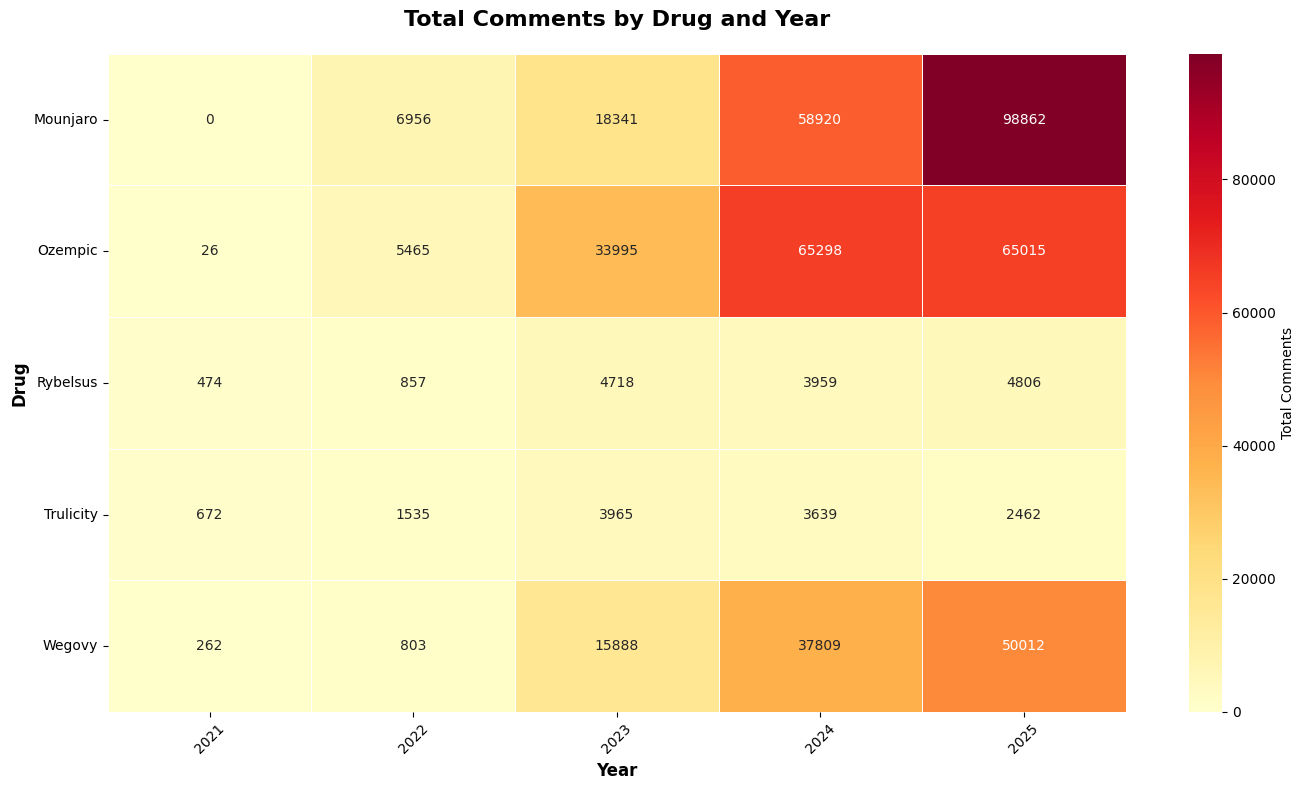


📊 HEATMAP SUMMARY STATISTICS
Years covered: 2021 - 2025
Total drugs: 5

🏆 Total comments by drug:
  Mounjaro: 183,079 comments
  Ozempic: 169,799 comments
  Wegovy: 104,774 comments
  Rybelsus: 14,814 comments
  Trulicity: 12,273 comments

📅 Total comments by year:
  2021: 1,434 comments
  2022: 15,616 comments
  2023: 76,907 comments
  2024: 169,625 comments
  2025: 221,157 comments

🔥 Peak year for each drug:
  Mounjaro: 2025 (98,862 comments)
  Ozempic: 2024 (65,298 comments)
  Rybelsus: 2025 (4,806 comments)
  Trulicity: 2023 (3,965 comments)
  Wegovy: 2025 (50,012 comments)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a list of all dataframes with their names
datasets = [
    ('Rybelsus', df_rybelsus),
    ('Ozempic', df_ozempic),
    ('Trulicity', df_trulicity),
    ('Wegovy', df_wegovy),
    ('Mounjaro', df_mounjaro)
]

# Create a summary dataframe for the heatmap
heatmap_data = []

for drug_name, df in datasets:
    if not df.empty:
        # Filter data from 2021 onwards
        df_filtered = df[df['year'] >= 2021]

        # Group by year and sum comments
        yearly_comments = df_filtered.groupby('year')['num_comments'].sum()

        for year, comments in yearly_comments.items():
            heatmap_data.append({
                'Drug': drug_name,
                'Year': year,
                'Comments': comments
            })

# Convert to DataFrame
heatmap_df = pd.DataFrame(heatmap_data)

# Pivot to create matrix format for heatmap
if not heatmap_df.empty:
    pivot_df = heatmap_df.pivot(index='Drug', columns='Year', values='Comments')
    pivot_df = pivot_df.fillna(0)  # Fill missing values with 0

    # Create the heatmap
    plt.figure(figsize=(14, 8))

    # Create heatmap with annotations
    sns.heatmap(pivot_df,
                annot=True,
                fmt='.0f',  # Format numbers as integers
                cmap='YlOrRd',  # Color scheme from light yellow to dark red
                cbar_kws={'label': 'Total Comments'},
                linewidths=0.5,
                annot_kws={'size': 10})

    plt.title('Total Comments by Drug and Year', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Year', fontsize=12, fontweight='bold')
    plt.ylabel('Drug', fontsize=12, fontweight='bold')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print summary statistics
    print("\n" + "="*50)
    print("📊 HEATMAP SUMMARY STATISTICS")
    print("="*50)

    print(f"Years covered: {pivot_df.columns.min()} - {pivot_df.columns.max()}")
    print(f"Total drugs: {len(pivot_df.index)}")

    # Show totals per drug
    drug_totals = pivot_df.sum(axis=1).sort_values(ascending=False)
    print(f"\n🏆 Total comments by drug:")
    for drug, total in drug_totals.items():
        print(f"  {drug}: {total:,.0f} comments")

    # Show totals per year
    year_totals = pivot_df.sum(axis=0).sort_index()
    print(f"\n📅 Total comments by year:")
    for year, total in year_totals.items():
        print(f"  {year}: {total:,.0f} comments")

    # Show peak year for each drug
    print(f"\n🔥 Peak year for each drug:")
    for drug in pivot_df.index:
        peak_year = pivot_df.loc[drug].idxmax()
        peak_comments = pivot_df.loc[drug, peak_year]
        print(f"  {drug}: {peak_year} ({peak_comments:,.0f} comments)")

else:
    print("⚠️ No data available for heatmap")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
